# Pothole Detection

This project shows how to implement a transfer learning and CNN based solution to solve image classification problems. Data from the [Pothole and Plain Road Images](https://www.kaggle.com/virenbr11/pothole-and-plain-rode-images) Kaggle dataset is used in this project. 


## Imports

In [1]:
import os
import shutil
from keras.preprocessing.image import ImageDataGenerator

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

## Setting directory paths

In [3]:
base_dir = r"C:/Users/Anmol Choubey/Downloads/Data/Data"

In [4]:
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir,'test')
validation_dir = os.path.join(base_dir,'validation')

In [5]:
train_plain_dir = os.path.join(train_dir,'plain')
train_pothole_dir = os.path.join(train_dir,'pothole')

In [6]:
test_plain_dir = os.path.join(test_dir,'plain')
test_pothole_dir = os.path.join(test_dir,'pothole')

In [7]:
validation_plain_dir = os.path.join(validation_dir,'plain')
validation_pothole_dir = os.path.join(validation_dir,'pothole')

In [8]:
# Sanity checks
print('total training plain images :', len(os.listdir(train_plain_dir)))
print('total training pothole images : ',len(os.listdir(train_pothole_dir)))
print('total validation plain images :', len(os.listdir(validation_plain_dir)))
print('total validation pothole images :', len(os.listdir(validation_pothole_dir)))
print('total test plain images :', len(os.listdir(test_plain_dir)))
print('total test pothole images :', len(os.listdir(test_pothole_dir)))

total training plain images : 210
total training pothole images :  211
total validation plain images : 70
total validation pothole images : 70
total test plain images : 70
total test pothole images : 70


## Re-scaling images to 224 X 224 to match VGG16 input size

In [9]:
train_size, validation_size, test_size = 420,140,140
img_width, img_height = 224, 224

So now we have a <b><u>balanced dataset</u></b> with:
* 420 training images    (210 pothole + 210 plain road).
* 140 validation images  (70 pothole + 70 plain road).
* 140 test images        (70 pothole + 70 plain road).

22.pngtree-smooth-roads-png-image_4433653.jpg


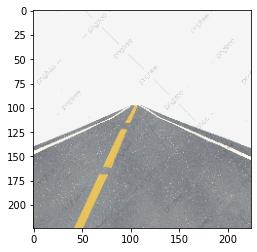

145.Pothole-full_450053_7.jpg


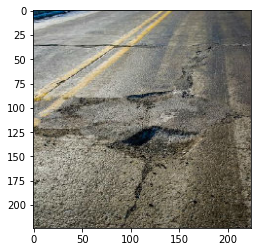

11.driving-country-roads-shutterstock-78677713.jpg


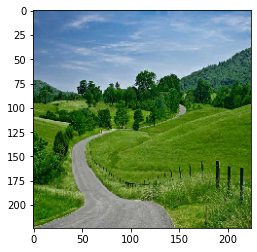

37.torcaaroads.jpg


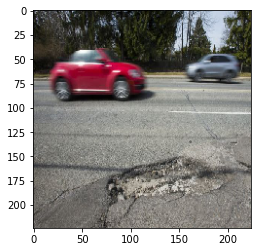

In [10]:
def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)
    print(random_img)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,2):
    show_pictures(train_plain_dir)
    show_pictures(train_pothole_dir)

## Obtaining the pre-trained weights from VGG16 for the Convolutional Base

In [11]:
from keras.applications import VGG16

# Input Shape: (224 X 224 X 3) where 3 is the number of input color channels, RGB
conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

In [12]:
# Check architecture
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Loading Dataset

In [13]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(test_dir, test_size)

Found 420 images belonging to 2 classes.


C:\Users\Anmol Choubey\anaconda3\envs\deeplearning\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Found 140 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


In [14]:
# Debug
print(train_features)
print(train_labels)

[[[[5.73294759e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.02533901e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    6.82672679e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.24354804e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.44786870e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    6.21377945e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.94615161e-01 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 3.54863405e-01 ... 0.00000000e+00
    7.70992041e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 2.40849942e-01 ... 0.00000000e+00
    3.17765176e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 2.46251792e-01 ... 0.00000000e+00
    3.51307869e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 5.23677588e-01 ... 0.00

In [15]:
train_features.shape

(420, 7, 7, 512)

## Classifier1: Fully Connected Layer Model
### Model Definition

In [16]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,512)))
model.add(layers.Dense(256, activation='relu', input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [18]:
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Epoch 1/100
14/14 [==============================] - 1s 46ms/step - loss: 1.0981 - acc: 0.7762 - val_loss: 0.2972 - val_acc: 0.9357
Epoch 2/100
14/14 [==============================] - 0s 35ms/step - loss: 0.3931 - acc: 0.9190 - val_loss: 0.6016 - val_acc: 0.9000
Epoch 3/100
14/14 [==============================] - 1s 37ms/step - loss: 0.2836 - acc: 0.9476 - val_loss: 0.1348 - val_acc: 0.9643
Epoch 4/100
14/14 [==============================] - 1s 36ms/step - loss: 0.0332 - acc: 0.9881 - val_loss: 0.1146 - val_acc: 0.9714
Epoch 5/100
14/14 [==============================] - 1s 41ms/step - loss: 0.0656 - acc: 0.9786 - val_loss: 0.1311 - val_acc: 0.9643
Epoch 6/100
14/14 [==============================] - 0s 35ms/step - loss: 0.0276 - acc: 0.9905 - val_loss: 0.1089 - val_acc: 0.9786
Epoch 7/100
14/14 [==============================] - 1s 36ms/step - loss: 0.0125 - acc: 0.9952 - val_loss: 0.1328 - val_acc: 0.9643
Epoch 8/100
14/14 [==============================] - 0s 35ms/step - loss: 0.

In [19]:
# Save model
model.save('pothole_fcl.h5')

In [20]:
from tensorflow import keras
# Load model
model = keras.models.load_model('pothole_fcl.h5')

### Classifier1: Fully Connected Layer Model Evaluation

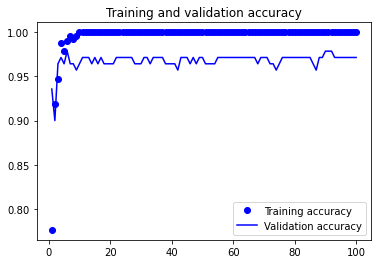

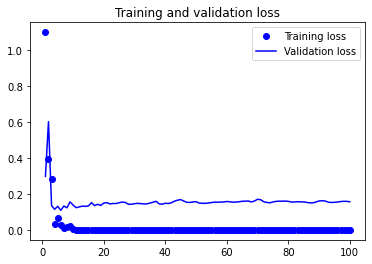

In [21]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Classifier1: Fully Connected Layer Model in Action

In [22]:
# Define function to visualize predictions
def visualize_predictions(classifier, n_cases):
    for i in range(0,n_cases):
        path = random.choice([test_plain_dir, test_pothole_dir])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Extract features
        features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

        # Make prediction
        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(features.reshape(1, 7*7*512))

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print('Plain')
        else:
            print('Pothole')

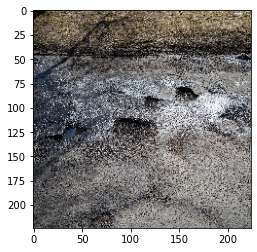

Pothole


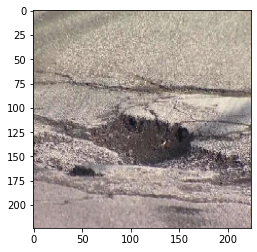

Pothole


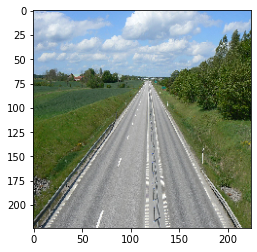

Plain


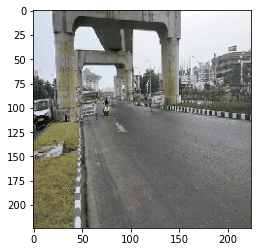

Plain


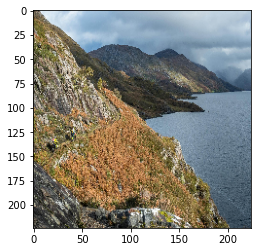

Pothole


In [23]:
# Visualize predictions
visualize_predictions(model, 5)

### Classifier1: Fully Connected Layer Model Performance Metrics

In [24]:
# Define function to visualize predictions
def test_output(classifier):
    result = []
    for f in test_features:
      try:
          prediction = classifier.predict(f)
      except:
          prediction = classifier.predict(f.reshape(1, 7, 7, 512))
      if(prediction < 0.5):
        result.append(0)
      else:
        result.append(1)
        
    return result
o = test_output(model)


Confusion Matrix: 
[[68  2]
 [ 2 68]]
Accuracy:  0.9714285714285714
Specificity:  0.9714285714285714
Precision/Positive Predictive Value:  0.9714285714285714
Negative Predictive Value:  0.9714285714285714
Recall/Sensitivity:  0.9714285714285714
False Positive Rate:  0.5
False Negative Rate:  0.02857142857142857
Positive Likelihood Ratio:  1.9428571428571428
Negative Likelihod Ratio:  0.029411764705882353
Diagnostic Odds Ratio:  66.05714285714286
False Omission Rate:  0.02857142857142857
F1 Score:  0.9714285714285714
Area under ROC curve:  0.9714285714285715


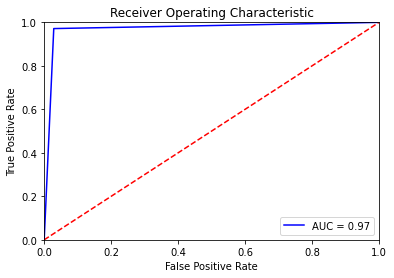

In [25]:
from sklearn.metrics import *
matrix = confusion_matrix(test_labels, o)
print("Confusion Matrix: ")
print(matrix)
[[tn, fp], [fn, tp]] = matrix

acc_score = accuracy_score(test_labels, o)
precision = precision_score(test_labels, o)
recall = tpr = recall_score(test_labels, o)
f1 = f1_score(test_labels, o)
roc_score = roc_auc_score(test_labels, o)
spc = tnr = tn/(tn + fp)
fpr = fp/(fp + fn)
fnr = fn/(fn+tp)
plr = tpr/fpr
nlr = fnr/tnr
dor = plr/nlr
npv = tn/(fn+tn)
fr = fn/(fn+tn)

print("Accuracy: ", acc_score)
print("Specificity: ", spc)
print("Precision/Positive Predictive Value: ", precision)
print("Negative Predictive Value: ", npv)
print("Recall/Sensitivity: ", recall)
print("False Positive Rate: ", fpr)
print("False Negative Rate: ", fnr)
print("Positive Likelihood Ratio: ", plr)
print("Negative Likelihod Ratio: ", nlr)
print("Diagnostic Odds Ratio: ", dor)
print("False Omission Rate: ", fr)
print("F1 Score: ", f1)
print("Area under ROC curve: ", roc_score)


fpr, tpr, threshold = roc_curve(test_labels, o)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Classifier2: Global Average Pooling Model
### Model Definition

The difference between this case and the previous one is that, instead of adding a stack of fully-connected layers, we will add a global average pooling layer and fed its output into a sigmoid activated layer.

We are using the sigmoid activation because in Keras, to perform binary classification, you should use sigmoid activation and binary_crossentropy as the loss.

In [26]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.GlobalAveragePooling2D(input_shape=(7,7,512)))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [28]:
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Epoch 1/100
14/14 [==============================] - 0s 10ms/step - loss: 0.7698 - acc: 0.4976 - val_loss: 0.7081 - val_acc: 0.4857
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 0.6912 - acc: 0.5310 - val_loss: 0.6713 - val_acc: 0.6071
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 0.6571 - acc: 0.6595 - val_loss: 0.6370 - val_acc: 0.6857
Epoch 4/100
14/14 [==============================] - 0s 4ms/step - loss: 0.6160 - acc: 0.8071 - val_loss: 0.6061 - val_acc: 0.7929
Epoch 5/100
14/14 [==============================] - 0s 4ms/step - loss: 0.5857 - acc: 0.8167 - val_loss: 0.5785 - val_acc: 0.8429
Epoch 6/100
14/14 [==============================] - 0s 4ms/step - loss: 0.5546 - acc: 0.8833 - val_loss: 0.5534 - val_acc: 0.8643
Epoch 7/100
14/14 [==============================] - 0s 4ms/step - loss: 0.5277 - acc: 0.9048 - val_loss: 0.5311 - val_acc: 0.8786
Epoch 8/100
14/14 [==============================] - 0s 3ms/step - loss: 0.5026 - 

In [29]:
# Save model
model.save('pothole_gap.h5')

In [30]:
from tensorflow import keras
# Load model
model2 = keras.models.load_model('pothole_gap.h5')

### Classifier2: Global Average Pooling Model Evaluation

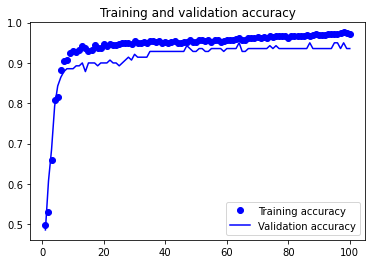

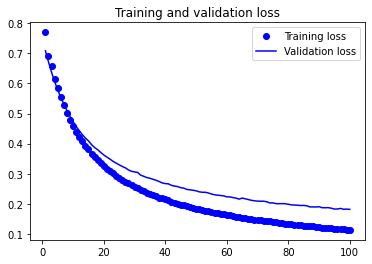

In [31]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Classifier2: Global Average Pooling Model in Action

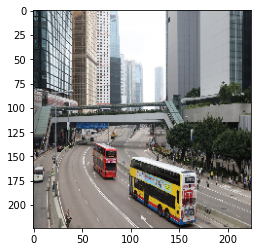

Plain


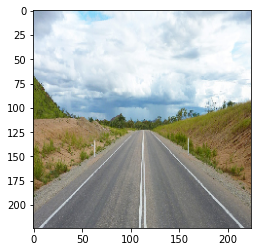

Plain


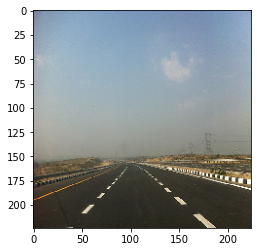

Plain


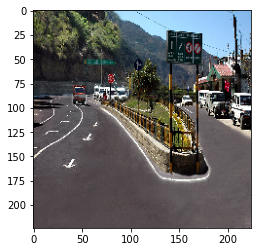

Plain


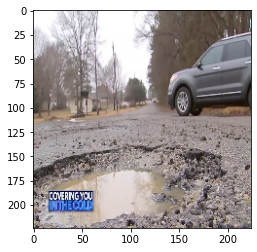

Pothole


In [32]:
# Visualize predictions
visualize_predictions(model, 5)

### Classifier2: Global Average Pooling Model Performance Metrics

In [33]:
# Define function to visualize predictions
def test_output(classifier):
    result = []
    for f in test_features:
      try:
          prediction = classifier.predict(f)
      except:
          prediction = classifier.predict(f.reshape(1, 7, 7, 512))
      if(prediction < 0.5):
        result.append(0)
      else:
        result.append(1)
        
    return result
o = test_output(model)


Confusion Matrix: 
[[65  5]
 [ 5 65]]
Accuracy:  0.9285714285714286
Specificity:  0.9285714285714286
Precision/Positive Predictive Value:  0.9285714285714286
Negative Predictive Value:  0.9285714285714286
Recall/Sensitivity:  0.9285714285714286
False Positive Rate:  0.5
False Negative Rate:  0.07142857142857142
Positive Likelihood Ratio:  1.8571428571428572
Negative Likelihod Ratio:  0.07692307692307691
Diagnostic Odds Ratio:  24.142857142857146
False Omission Rate:  0.07142857142857142
F1 Score:  0.9285714285714286
Area under ROC curve:  0.9285714285714286


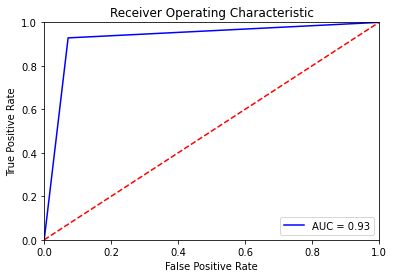

In [34]:
from sklearn.metrics import *
matrix = confusion_matrix(test_labels, o)
print("Confusion Matrix: ")
print(matrix)
[[tn, fp], [fn, tp]] = matrix

acc_score = accuracy_score(test_labels, o)
precision = precision_score(test_labels, o)
recall = tpr = recall_score(test_labels, o)
f1 = f1_score(test_labels, o)
roc_score = roc_auc_score(test_labels, o)
spc = tnr = tn/(tn + fp)
fpr = fp/(fp + fn)
fnr = fn/(fn+tp)
plr = tpr/fpr
nlr = fnr/tnr
dor = plr/nlr
npv = tn/(fn+tn)
fr = fn/(fn+tn)

print("Accuracy: ", acc_score)
print("Specificity: ", spc)
print("Precision/Positive Predictive Value: ", precision)
print("Negative Predictive Value: ", npv)
print("Recall/Sensitivity: ", recall)
print("False Positive Rate: ", fpr)
print("False Negative Rate: ", fnr)
print("Positive Likelihood Ratio: ", plr)
print("Negative Likelihod Ratio: ", nlr)
print("Diagnostic Odds Ratio: ", dor)
print("False Omission Rate: ", fr)
print("F1 Score: ", f1)
print("Area under ROC curve: ", roc_score)


fpr, tpr, threshold = roc_curve(test_labels, o)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Classifier3: Linear Support Vector Machine Model
### Model Definition

In [35]:
# Concatenate training and validation sets
svm_features = np.concatenate((train_features, validation_features))
svm_labels = np.concatenate((train_labels, validation_labels))

In [36]:
svm_labels

array([0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
       1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
       1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 1.

In [37]:
svm_features.shape

(560, 7, 7, 512)

In [38]:
# Build model
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

X_train, y_train = svm_features.reshape(560,7*7*512), svm_labels

param = [{
          "C": [0.01, 0.1, 1, 10, 100]
         }]
 
svm = LinearSVC(penalty='l2', loss='squared_hinge',max_iter=10000)  # As in Tang (2013)
clf = GridSearchCV(svm, param, cv=10,verbose=10)
clf.fit(X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10; 1/5] START C=0.01.....................................................
[CV 1/10; 1/5] END ...................................C=0.01; total time=   2.1s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   2.2s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   2.2s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   2.3s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   1.9s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END .............................

C:\Users\Anmol Choubey\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/10; 3/5] END ......................................C=1; total time=  24.7s
[CV 4/10; 3/5] START C=1........................................................
[CV 4/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=  16.1s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END .........

GridSearchCV(cv=10, estimator=LinearSVC(max_iter=10000),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}], verbose=10)

In [39]:
# Save model
import joblib
joblib.dump(clf, 'pothole_svm.pkl')

['pothole_svm.pkl']

In [40]:
import joblib
# Load model
clf = joblib.load('pothole_svm.pkl')

In [41]:
clf

GridSearchCV(cv=10, estimator=LinearSVC(max_iter=10000),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}], verbose=10)

### Classifier3: Linear Support Vector Machine Model Evaluation

In [42]:
# Evaluate model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

print("\nAccuracy score (mean):")
acc_mean = np.mean(cross_val_score(clf, X_train, y_train, cv=10,verbose=10))
# print(cvss)

print("\nAccuracy score (standard deviation):")
acc_std = np.std(cross_val_score(clf, X_train, y_train, cv=10,verbose=10))
# print(asss)


Accuracy score (mean):
[CV] START .....................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10; 1/5] START C=0.01.....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/10; 1/5] END ...................................C=0.01; total time=   1.5s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   2.1s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   2.1s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   2.0s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   1.8s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   1.1s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

C:\Users\Anmol Choubey\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 9/10; 3/5] END ......................................C=1; total time=  32.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.2s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   1.8s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   1.7s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   2.0s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   1.4s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   0.7s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   2.0s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.4min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   2.2s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   1.6s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   2.3s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   2.9s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   1.8s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   3.0s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

C:\Users\Anmol Choubey\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 9/10; 3/5] END ......................................C=1; total time=  23.5s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.9s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.3s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   1.3s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .........

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.2min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   2.3s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   1.5s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   1.8s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   2.3s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   1.6s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   2.1s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 12.6min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   1.6s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   1.8s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   1.9s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   1.6s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   0.8s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   1.8s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 14.8min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   0.9s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   0.8s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   0.9s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   0.8s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   1.0s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   0.9s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 15.8min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   2.3s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   1.9s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   2.0s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   2.1s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   2.2s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   2.4s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

C:\Users\Anmol Choubey\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/10; 3/5] END ......................................C=1; total time=  24.7s
[CV 4/10; 3/5] START C=1........................................................
[CV 4/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 5/10; 3/5] START C=1........................................................


C:\Users\Anmol Choubey\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/10; 3/5] END ......................................C=1; total time=  26.2s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 8/10; 3/5] START C=1........................................................


C:\Users\Anmol Choubey\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 8/10; 3/5] END ......................................C=1; total time=  23.3s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=  18.8s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.1s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.2s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 19.8min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   2.1s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   2.3s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   2.2s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   1.8s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   1.7s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   1.8s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

C:\Users\Anmol Choubey\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 8/10; 3/5] END ......................................C=1; total time=  23.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.2s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 22.4min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   1.7s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   1.7s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   2.2s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   1.9s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   2.1s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   2.3s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 25.6min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   0.9s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   0.8s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   1.0s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   1.2s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   0.9s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   0.8s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 26.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/10; 1/5] END ...................................C=0.01; total time=   1.4s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   2.0s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   2.2s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   2.3s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   1.9s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   1.3s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   1.9s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   1.1s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   1.8s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   0.8s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   1.0s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   2.0s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

C:\Users\Anmol Choubey\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/10; 3/5] END ......................................C=1; total time=  26.0s
[CV 3/10; 3/5] START C=1........................................................
[CV 3/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 4/10; 3/5] START C=1........................................................


C:\Users\Anmol Choubey\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/10; 3/5] END ......................................C=1; total time=  27.7s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=  13.3s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=  17.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END ........

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.5min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   1.6s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   2.1s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   2.2s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   2.9s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   2.4s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   1.5s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.6min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   1.9s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   0.9s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   2.5s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   1.5s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   1.6s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   2.0s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 13.0min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   1.5s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   1.4s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   1.8s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   1.7s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   0.8s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   1.3s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 14.9min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   1.6s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   1.7s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   1.6s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   0.9s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   1.6s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   1.2s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 16.2min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   3.2s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   2.3s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   2.4s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   2.2s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   2.1s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   2.8s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

C:\Users\Anmol Choubey\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/10; 3/5] END ......................................C=1; total time=  37.4s
[CV 2/10; 3/5] START C=1........................................................
[CV 2/10; 3/5] END ......................................C=1; total time=   1.5s
[CV 3/10; 3/5] START C=1........................................................


C:\Users\Anmol Choubey\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/10; 3/5] END ......................................C=1; total time=  30.4s
[CV 4/10; 3/5] START C=1........................................................
[CV 4/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=   2.0s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=  16.3s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   2.0s
[CV 8/10; 3/5] START C=1........................................................


C:\Users\Anmol Choubey\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 8/10; 3/5] END ......................................C=1; total time=  32.5s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   2.9s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   2.3s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 21.2min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   2.5s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   2.7s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   1.9s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   1.8s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   1.8s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   1.8s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 24.5min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   1.7s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   1.6s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   1.7s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   1.9s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   1.6s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   1.9s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

C:\Users\Anmol Choubey\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/10; 3/5] END ......................................C=1; total time=  23.7s
[CV 3/10; 3/5] START C=1........................................................
[CV 3/10; 3/5] END ......................................C=1; total time=   1.7s
[CV 4/10; 3/5] START C=1........................................................
[CV 4/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 8/10; 3/5] START C=1........................................................


C:\Users\Anmol Choubey\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 8/10; 3/5] END ......................................C=1; total time=  23.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   2.7s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.1s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 27.5min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   0.8s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   0.8s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   1.1s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   0.8s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   0.8s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   0.8s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 28.5min finished


In [43]:
print("Accuracy score (mean) :", acc_mean)
print("\nAccuracy score (standard deviation) :", acc_std)

Accuracy score (mean) : 0.9714285714285715

Accuracy score (standard deviation) : 0.025505101530510176


In [44]:
# Plot learning curves
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator = clf,
                                                        X = X_train,
                                                        y = y_train,
                                                        train_sizes = np.linspace(0.1,1.0,10),
                                                        cv = 10,verbose=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


[learning_curve] Training set sizes: [ 50 100 151 201 252 302 352 403 453 504]
[CV] START .....................................................................
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10; 1/5] START C=0.01.....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 1/10; 1/5] END ...................................C=0.01; total time=   0.1s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   0.0s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   0.0s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   0.1s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   0.0s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   0.0s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   0.4s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   0.2s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   0.1s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   0.1s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   0.1s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   0.1s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.5s remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   0.3s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   0.3s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   0.3s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   0.4s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   0.3s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   0.3s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   44.3s remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   0.3s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   0.3s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   0.3s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   0.3s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   0.3s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   0.3s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.1min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   0.4s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   0.4s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   0.4s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   0.6s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   0.5s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   0.5s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   0.5s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   1.3s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   1.4s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   1.5s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   1.5s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   1.2s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.7min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   0.8s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   0.7s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   0.8s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   0.6s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   0.6s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   0.6s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.4min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   0.7s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   1.1s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   0.7s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   1.3s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   1.1s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   0.7s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  4.5min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   0.9s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   1.0s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   1.1s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   1.0s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   1.0s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   0.8s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  5.4min remaining:    0.0s


[CV 1/10; 1/5] END ...................................C=0.01; total time=   1.8s
[CV 2/10; 1/5] START C=0.01.....................................................
[CV 2/10; 1/5] END ...................................C=0.01; total time=   2.2s
[CV 3/10; 1/5] START C=0.01.....................................................
[CV 3/10; 1/5] END ...................................C=0.01; total time=   2.0s
[CV 4/10; 1/5] START C=0.01.....................................................
[CV 4/10; 1/5] END ...................................C=0.01; total time=   2.3s
[CV 5/10; 1/5] START C=0.01.....................................................
[CV 5/10; 1/5] END ...................................C=0.01; total time=   1.9s
[CV 6/10; 1/5] START C=0.01.....................................................
[CV 6/10; 1/5] END ...................................C=0.01; total time=   1.7s
[CV 7/10; 1/5] START C=0.01.....................................................
[CV 7/10; 1/5] END .........

C:\Users\Anmol Choubey\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/10; 3/5] END ......................................C=1; total time=  30.9s
[CV 4/10; 3/5] START C=1........................................................
[CV 4/10; 3/5] END ......................................C=1; total time=   3.0s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=   1.5s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 9/10; 3/5] START C=1........................................................


C:\Users\Anmol Choubey\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 9/10; 3/5] END ......................................C=1; total time=  28.9s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.1s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.5s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.3s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   1.6s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .........

[CV 9/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.0s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.0s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.0s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   0.0s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .........

[CV 9/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .........

[CV 9/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.3s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .........

[CV 9/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .........

[CV 9/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .........

[CV 9/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.7s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .........

[CV 9/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   2.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .........

[CV 9/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.8s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.2s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .........

[CV 9/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.9s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.2s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 5/10; 4/5] START C=10.......................................................
[CV 5/10; 4/5] END .........

C:\Users\Anmol Choubey\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 8/10; 3/5] END ......................................C=1; total time=  26.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.7s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.0s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.0s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.0s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.6s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.6s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.7s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.8s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   1.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.9s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   2.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.6s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.0s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.0s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.0s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.6s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.3s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.1s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.7s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.1s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   1.2s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

[CV 8/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.8s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 4/10; 4/5] START C=10.......................................................
[CV 4/10; 4/5] END .........

C:\Users\Anmol Choubey\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/10; 3/5] END ......................................C=1; total time=  32.4s
[CV 4/10; 3/5] START C=1........................................................
[CV 4/10; 3/5] END ......................................C=1; total time=  15.1s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   6.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END .........

[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.1s
[CV 1/10; 4/5] START C=10...

[CV 4/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END ........

[CV 4/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END ........

[CV 4/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END ........

[CV 4/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END ........

[CV 4/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END ........

[CV 4/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END ........

[CV 4/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END ........

[CV 4/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.7s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END ........

[CV 4/10; 3/5] END ......................................C=1; total time=   7.7s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=   1.4s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=  21.4s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END ........

[CV 5/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .........

[CV 5/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.1s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .........

[CV 5/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .........

[CV 5/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .........

[CV 5/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .........

[CV 5/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .........

[CV 5/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.6s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .........

[CV 5/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.7s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .........

[CV 5/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.1s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .........

[CV 5/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.3s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.9s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.0s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.3s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.6s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.8s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.6s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   8.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.8s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 6/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

C:\Users\Anmol Choubey\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 6/10; 3/5] END ......................................C=1; total time=  25.5s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   3.9s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.2s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.0s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.0s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.3s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.4s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.7s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.9s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

C:\Users\Anmol Choubey\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/10; 3/5] END ......................................C=1; total time=  22.2s
[CV 5/10; 3/5] START C=1........................................................
[CV 5/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=  14.2s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   6.5s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END ........

[CV 5/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .........

[CV 5/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .........

[CV 5/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .........

[CV 5/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.3s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .........

[CV 5/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.6s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .........

[CV 5/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .........

[CV 5/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .........

[CV 5/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.6s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .........

[CV 5/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.7s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .........

C:\Users\Anmol Choubey\anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/10; 3/5] END ......................................C=1; total time=  21.7s
[CV 6/10; 3/5] START C=1........................................................
[CV 6/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 7/10; 3/5] START C=1........................................................
[CV 7/10; 3/5] END ......................................C=1; total time=   1.2s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   8.7s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   1.0s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.1s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.0s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.0s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.1s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.1s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.1s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.2s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.2s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.2s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.3s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.4s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.3s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.4s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.5s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.5s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.5s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.6s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.6s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.7s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.6s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.7s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.7s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.8s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   1.0s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   2.8s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   0.9s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   0.8s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[CV 7/10; 3/5] END ......................................C=1; total time=   1.1s
[CV 8/10; 3/5] START C=1........................................................
[CV 8/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 9/10; 3/5] START C=1........................................................
[CV 9/10; 3/5] END ......................................C=1; total time=   0.9s
[CV 10/10; 3/5] START C=1.......................................................
[CV 10/10; 3/5] END .....................................C=1; total time=   0.8s
[CV 1/10; 4/5] START C=10.......................................................
[CV 1/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 2/10; 4/5] START C=10.......................................................
[CV 2/10; 4/5] END .....................................C=10; total time=   1.0s
[CV 3/10; 4/5] START C=10.......................................................
[CV 3/10; 4/5] END .........

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 75.0min finished


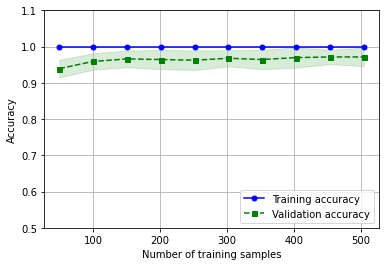

In [45]:
plt.plot(train_sizes, train_mean, color='blue', 
         marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')


plt.plot(train_sizes, test_mean, color='green', linestyle='--',
         marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.1])
plt.show()

### Classifier3: Linear Support Vector Machine Model in Action

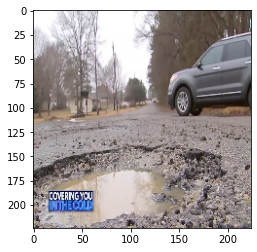

Pothole


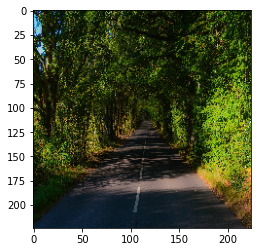

Plain


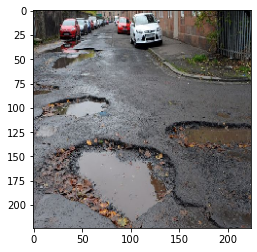

Pothole


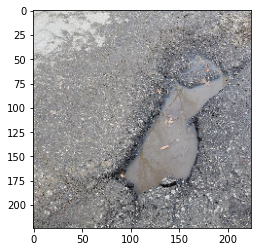

Pothole


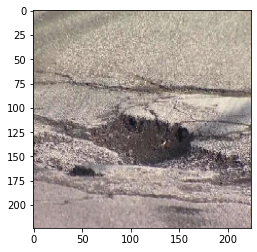

Pothole


In [46]:
# Visualize predictions
visualize_predictions(clf, 5)

### Classifier3: Linear Support Vector Machine Model Performance Metrics

In [47]:
# Define function to visualize predictions
def test_output(classifier):
    result = []
    for f in test_features:
      try:
          prediction = classifier.predict(f)
      except:
          prediction = classifier.predict(f.reshape(1, 7*7*512))
      if(prediction < 0.5):
        result.append(0)
      else:
        result.append(1)
        
    return result
o = test_output(clf)


Confusion Matrix: 
[[67  3]
 [ 3 67]]
Accuracy:  0.9571428571428572
Specificity:  0.9571428571428572
Precision/Positive Predictive Value:  0.9571428571428572
Negative Predictive Value:  0.9571428571428572
Recall/Sensitivity:  0.9571428571428572
False Positive Rate:  0.5
False Negative Rate:  0.04285714285714286
Positive Likelihood Ratio:  1.9142857142857144
Negative Likelihod Ratio:  0.04477611940298507
Diagnostic Odds Ratio:  42.75238095238095
False Omission Rate:  0.04285714285714286
F1 Score:  0.9571428571428572
Area under ROC curve:  0.9571428571428572


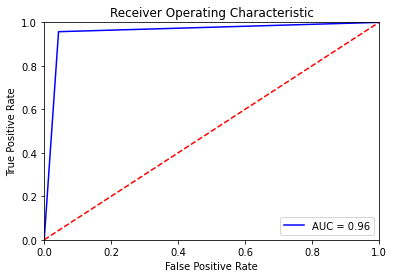

In [48]:
from sklearn.metrics import *
matrix = confusion_matrix(test_labels, o)
print("Confusion Matrix: ")
print(matrix)
[[tn, fp], [fn, tp]] = matrix

acc_score = accuracy_score(test_labels, o)
precision = precision_score(test_labels, o)
recall = tpr = recall_score(test_labels, o)
f1 = f1_score(test_labels, o)
roc_score = roc_auc_score(test_labels, o)
spc = tnr = tn/(tn + fp)
fpr = fp/(fp + fn)
fnr = fn/(fn+tp)
plr = tpr/fpr
nlr = fnr/tnr
dor = plr/nlr
npv = tn/(fn+tn)
fr = fn/(fn+tn)

print("Accuracy: ", acc_score)
print("Specificity: ", spc)
print("Precision/Positive Predictive Value: ", precision)
print("Negative Predictive Value: ", npv)
print("Recall/Sensitivity: ", recall)
print("False Positive Rate: ", fpr)
print("False Negative Rate: ", fnr)
print("Positive Likelihood Ratio: ", plr)
print("Negative Likelihod Ratio: ", nlr)
print("Diagnostic Odds Ratio: ", dor)
print("False Omission Rate: ", fr)
print("F1 Score: ", f1)
print("Area under ROC curve: ", roc_score)


fpr, tpr, threshold = roc_curve(test_labels, o)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [52]:
from PIL import Image

# Summary

# Single Image Class Prediction

In [59]:
def predict_class_single_img(img_path,classifier=model):
    
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  
    img_tensor /= 255.  

    # Extract features
    features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

    # Make prediction
    try:
        prediction = classifier.predict(features)
    except:
        prediction = classifier.predict(features.reshape(1, 7*7*512))

    # Show picture
    plt.imshow(img_tensor)
    plt.show()

    # Write prediction
    if prediction < 0.5:
        print('Plain')
    else:
        print('Pothole')

## Fully Connected Layer Model

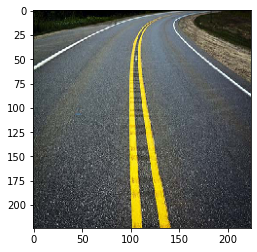

Plain


In [60]:
predict_class_single_img("road.jpg",model)

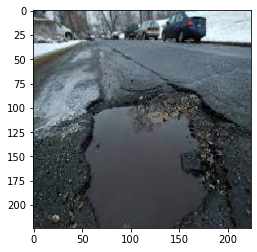

Pothole


In [69]:
predict_class_single_img("road1.jpg",model)

## Global Average Pooling Model

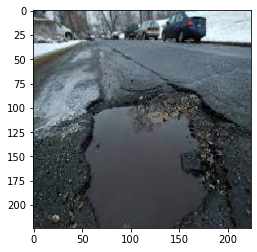

Pothole


In [63]:
predict_class_single_img("road1.jpg",model2)

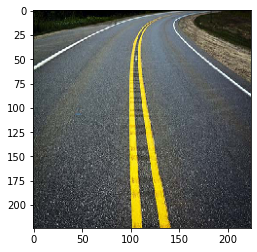

Plain


In [67]:
predict_class_single_img("road.jpg",model2)

## Linear Support Vector Machine Model

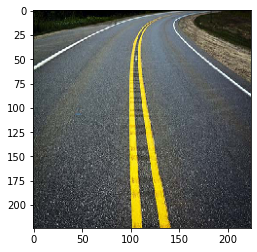

Plain


In [64]:
predict_class_single_img("road.jpg",clf)

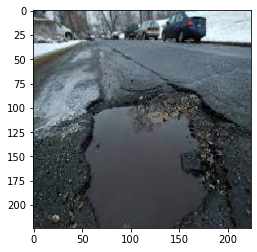

Pothole


In [66]:
predict_class_single_img("road1.jpg",clf)

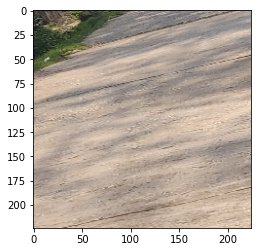

Plain


In [73]:
predict_class_single_img("im2.jpeg",clf)

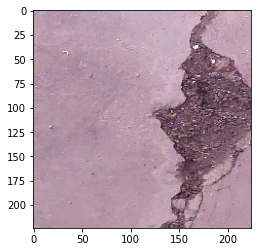

Pothole


In [77]:
predict_class_single_img("im3.jpeg",clf)